In [1]:
import numpy as np
np.random.seed(42)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Hopfield Network Class
class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train(self, patterns):
        for p in patterns:
            p = p.reshape(self.size, 1)
            self.weights += np.dot(p, p.T)
        np.fill_diagonal(self.weights, 0)

    def recall(self, pattern, steps=10):
        s = pattern.copy()
        for _ in range(steps):
            i = np.random.randint(0, self.size)
            s[i] = 1 if np.dot(self.weights[i], s) >= 0 else -1
        return s

In [6]:
def show(pattern, title):
    plt.imshow(pattern.reshape(10,10), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

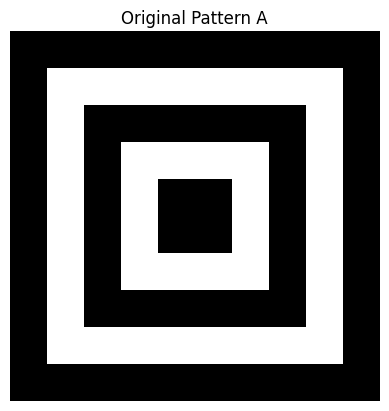

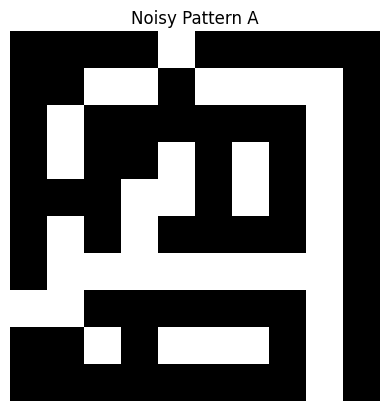

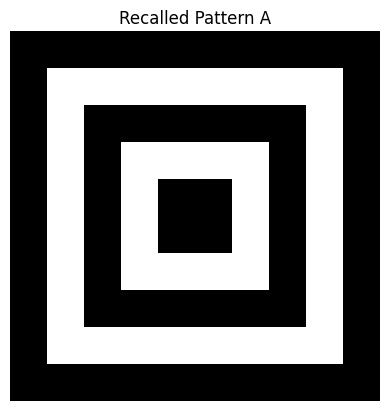

In [8]:
pattern_A = np.array([
    [1,1,1,1,1,1,1,1,1,1],
    [1,-1,-1,-1,-1,-1,-1,-1,-1,1],
    [1,-1,1,1,1,1,1,1,-1,1],
    [1,-1,1,-1,-1,-1,-1,1,-1,1],
    [1,-1,1,-1,1,1,-1,1,-1,1],
    [1,-1,1,-1,1,1,-1,1,-1,1],
    [1,-1,1,-1,-1,-1,-1,1,-1,1],
    [1,-1,1,1,1,1,1,1,-1,1],
    [1,-1,-1,-1,-1,-1,-1,-1,-1,1],
    [1,1,1,1,1,1,1,1,1,1],
]).reshape(100)

pattern_B = np.random.choice([-1,1], size=(100,))
pattern_C = np.random.choice([-1,1], size=(100,))

patterns = np.array([pattern_A, pattern_B, pattern_C])

# Train network
hopnet = HopfieldNetwork(100)
hopnet.train(patterns)

# Create noisy version
noisy = pattern_A.copy()
noise_idx = np.random.choice(range(100), size=15, replace=False)
noisy[noise_idx] *= -1

# Recall
recalled = hopnet.recall(noisy)

# Display
show(pattern_A, "Original Pattern A")
show(noisy, "Noisy Pattern A")
show(recalled, "Recalled Pattern A")

Storage capacity of Hopfield Network

In [9]:
class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train(self, patterns):
        for p in patterns:
            self.weights += np.outer(p, p)
        np.fill_diagonal(self.weights, 0)

    def recall(self, pattern, steps=10):
        s = pattern.copy()
        for _ in range(steps):
            i = np.random.randint(0, self.size)
            s[i] = 1 if np.dot(self.weights[i], s) >= 0 else -1
        return s

In [10]:
N = 100
max_patterns = 40  # try storing up to 40 patterns
success_list = []

for P in range(1, max_patterns + 1):
    patterns = np.random.choice([-1, 1], size=(P, N))
    hopnet = HopfieldNetwork(N)
    hopnet.train(patterns)

    success = 0
    for patt in patterns:
        noisy = patt.copy()
        idx = np.random.choice(range(N), size=10, replace=False)
        noisy[idx] *= -1
        recalled = hopnet.recall(noisy)
        if np.array_equal(recalled, patt):
            success += 1
    success_list.append(success / P)


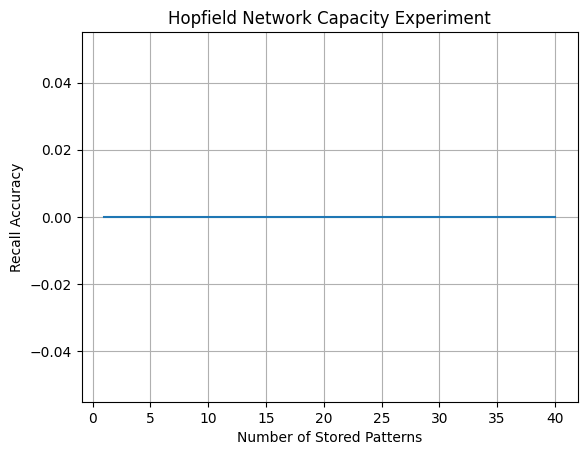

Approximate capacity where accuracy drops below 50%:
Capacity ≈ 1


In [11]:
import matplotlib.pyplot as plt
plt.plot(range(1, max_patterns + 1), success_list)
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Recall Accuracy")
plt.title("Hopfield Network Capacity Experiment")
plt.grid(True)
plt.show()

print("Approximate capacity where accuracy drops below 50%:")
for i, acc in enumerate(success_list):
    if acc < 0.5:
        print("Capacity ≈", i+1)
        break

Eight Rook Hopfield Implementation

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

np.random.seed(42)

In [17]:
def energy_eight_rook(V, A=8.0, B=8.0):
    """
    Compute the Hopfield-style energy for the eight-rook formulation.
    V: (8,8) array of 0/1
    """
    row_terms = np.sum(V, axis=1) - 1.0  # shape (8,)
    col_terms = np.sum(V, axis=0) - 1.0  # shape (8,)
    E = A * np.sum(row_terms**2) + B * np.sum(col_terms**2)
    return E

In [18]:
def one_async_update(V, A=8.0, B=8.0):
    """
    Perform one full asynchronous sweep (random order) updating each neuron once.
    Returns updated V and whether any change happened.
    """
    size = 8
    idxs = [(i,j) for i in range(size) for j in range(size)]
    np.random.shuffle(idxs)
    changed = False
    # Precompute sums and update incrementally for speed
    for (a,b) in idxs:
        # compute current row and col sums excluding current neuron
        row_sum = V[a,:].sum() - V[a,b]
        col_sum = V[:,b].sum() - V[a,b]
        # derivative of (sum_j V_ij -1)^2 wrt V_ab is 2*(row_sum + V_ab - 1)
        # net input (we want to decrease energy): -A*2*(row_sum + Vab -1) etc
        # simpler: net = -2*A*(row_sum + V_ab - 1) - 2*B*(col_sum + V_ab - 1)
        # but using V_ab excluded above, we add the current V[a,b] back in:
        net = -2.0 * A * (row_sum + V[a,b] - 1.0) - 2.0 * B * (col_sum + V[a,b] - 1.0)
        # update rule: set to 1 if net > 0, else 0; tie -> random
        new_val = 1 if net > 0 else 0
        if net == 0:
            # tie-breaker: random flip based on small prob
            new_val = np.random.choice([0,1])
        if new_val != V[a,b]:
            V[a,b] = new_val
            changed = True
    return V, changed


In [19]:
def is_valid_solution(V):
    """Check that each row and each column has exactly one rook."""
    return np.all(V.sum(axis=1) == 1) and np.all(V.sum(axis=0) == 1)

def solve_eight_rook(A=8.0, B=8.0, max_iters=200, restarts=50, verbose=True):
    """
    Try to solve with several random restarts.
    Returns (V_solution, success_flag, iters_used, restart_used)
    """
    best_V = None
    best_energy = np.inf
    t0 = time()
    for r in range(restarts):
        # random initial state (use low density to help)
        V = np.random.choice([0,1], size=(8,8), p=[0.85, 0.15]).astype(int)
        # optional: force at least one per row/col random initial
        for i in range(8):
            if V[i].sum() == 0:
                V[i, np.random.randint(8)] = 1
        for j in range(8):
            if V[:,j].sum() == 0:
                V[np.random.randint(8), j] = 1

        it = 0
        for it in range(1, max_iters+1):
            V, changed = one_async_update(V, A=A, B=B)
            if is_valid_solution(V):
                if verbose:
                    print(f"Found valid solution on restart {r+1} at iter {it} (time {time()-t0:.2f}s)")
                return V, True, it, r+1
            # early exit if stable but invalid (no change)
            if not changed:
                break

        E = energy_eight_rook(V, A=A, B=B)
        if E < best_energy:
            best_energy = E
            best_V = V.copy()
    if verbose:
        print(f"No valid solution found after {restarts} restarts (best energy {best_energy:.4f}).")
    return best_V, False, None, restarts


In [20]:
def print_board(V):
    """Print board with R for rook and . for empty"""
    size = V.shape[0]
    for i in range(size):
        row = ''.join(' R' if V[i,j] == 1 else ' .' for j in range(size))
        print(row)
    print()

def plot_board(V, title="Eight-Rook solution"):
    plt.figure(figsize=(4,4))
    plt.imshow(V, cmap='Greys', interpolation='nearest')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

No valid solution found after 100 restarts (best energy 32.0000).

Selected weights: A = 8.0 , B = 8.0
Reasoning: A,B large to strongly enforce row/column sum = 1 constraints (dominant terms).
If solver fails, increase A,B or increase restarts to explore more initializations.

Resulting board (1 = rook):

 . . . . . . . .
 . R . . . . . .
 . . . . . R . .
 . . . R . . . .
 . . . . R . . R
 R . . R . . . .
 . . . . . . R .
 . . R . . . . .



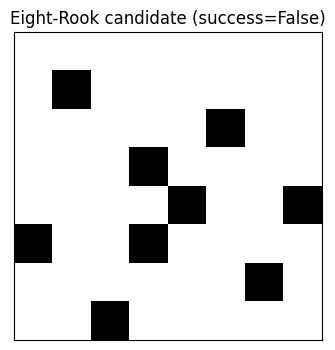

NOT a valid solution. Try increasing A,B or the number of restarts.


In [21]:
A = 8.0
B = 8.0
V_sol, success, iters, restart_used = solve_eight_rook(A=A, B=B, max_iters=300, restarts=100, verbose=True)

print("\nSelected weights: A =", A, ", B =", B)
print("Reasoning: A,B large to strongly enforce row/column sum = 1 constraints (dominant terms).")
print("If solver fails, increase A,B or increase restarts to explore more initializations.\n")

if V_sol is None:
    print("No candidate configuration produced.")
else:
    print("Resulting board (1 = rook):\n")
    print_board(V_sol)
    plot_board(V_sol, title=f"Eight-Rook candidate (success={success})")

# Validate explicitly
if success and is_valid_solution(V_sol):
    print("VALID solution: each row and column has exactly one rook.")
else:
    print("NOT a valid solution. Try increasing A,B or the number of restarts.")


Solution found at restart 128 iter 39
. . . . . . . R
. . . R . . . .
. . . . R . . .
. . . . . R . .
. . . . . . R .
. R . . . . . .
R . . . . . . .
. . R . . . . .

Valid: True
Energy: 0.0


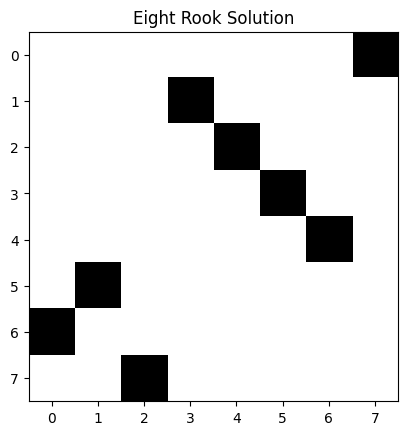

In [22]:
# Improved Eight-Rook Hopfield Solver - higher weights & row-constrained start
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

def energy(V, A=12.0, B=12.0):
    row_terms = np.sum(V, axis=1) - 1.0
    col_terms = np.sum(V, axis=0) - 1.0
    return A * np.sum(row_terms**2) + B * np.sum(col_terms**2)

def update(V, A=12.0, B=12.0):
    changed = False
    idxs = [(i,j) for i in range(8) for j in range(8)]
    np.random.shuffle(idxs)
    for (a,b) in idxs:
        row_sum = V[a,:].sum() - V[a,b]
        col_sum = V[:,b].sum() - V[a,b]
        net = -2*A*(row_sum + V[a,b] - 1) - 2*B*(col_sum + V[a,b] - 1)
        new_val = 1 if net>0 else 0
        if net == 0:
            new_val = np.random.choice([0,1])
        if new_val != V[a,b]:
            V[a,b] = new_val
            changed = True
    return V, changed

def is_valid(V):
    return np.all(V.sum(axis=1)==1) and np.all(V.sum(axis=0)==1)

def solve(max_iters=350, restarts=200):
    for r in range(restarts):
        # Initialize: exactly one rook per row at random column
        V = np.zeros((8,8), dtype=int)
        for i in range(8):
            V[i, np.random.randint(8)] = 1

        for it in range(max_iters):
            V, changed = update(V)
            if is_valid(V):
                print(f"Solution found at restart {r+1} iter {it+1}")
                return V, True
            if not changed:  # stuck
                break
    return V, False

def print_board(V):
    for i in range(8):
        print(' '.join('R' if V[i,j]==1 else '.' for j in range(8)))
    print()

V, ok = solve()

print_board(V)
print("Valid:", ok)
print("Energy:", energy(V))
plt.imshow(V, cmap='Greys')
plt.title("Eight Rook Solution")
plt.show()


TSP with Hopfield–Tank model

In [23]:
import numpy as np

np.random.seed(42)

In [24]:
def random_distance_matrix(N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    pts = np.random.rand(N, 2)
    D = np.sqrt(((pts[:, None, :] - pts[None, :, :])**2).sum(axis=2))
    return D, pts

In [25]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def hopfield_tsp_once(D, A=500.0, B=500.0, C=200.0, beta=5.0, dt=0.01, steps=3000):
    """
    One run of Hopfield-Tank dynamics.
    D: NxN distance matrix
    Returns: tour (list of city indices in visit order), tour_length, final V (NxN)
    """
    N = D.shape[0]
    # initialize membrane potentials small random
    U = 0.2 * np.random.randn(N, N)
    V = sigmoid(beta * U)

    def jp(j): return (j + 1) % N
    def jm(j): return (j - 1) % N

    for step in range(steps):
        V = sigmoid(beta * U)
        row_sum = V.sum(axis=1)   # shape (N,)
        col_sum = V.sum(axis=0)   # shape (N,)

        # compute dist coupling term: for each (i,j) sum_k D[i,k] * (V[k,j+1] + V[k,j-1])
        dist_term = np.zeros_like(V)
        for j in range(N):
            Vjp = V[:, jp(j)]
            Vjm = V[:, jm(j)]
            dist_term[:, j] = D @ (Vjp + Vjm)

        I = -A * (row_sum[:, None] - 1.0) - B * (col_sum[None, :] - 1.0) - C * dist_term
        dU = -U + I
        U = U + dt * dU

        # small stability check (optional early stop)
        if step % 500 == 0 and step > 0:
            # compute approximate energy to monitor (not strictly necessary)
            E1 = (A/2.0) * np.sum((row_sum - 1.0)**2)
            E2 = (B/2.0) * np.sum((col_sum - 1.0)**2)
            E3 = 0.0
            for j in range(N):
                Vj = V[:, j]
                Vjp = V[:, jp(j)]
                E3 += np.sum(D * np.outer(Vj, Vjp))
            E3 = (C/2.0) * E3
            # print(f"step {step} approx energy {E1+E2+E3:.4f}")

    V_final = sigmoid(beta * U)

    # decode V_final to a permutation (greedy with repair)
    tour, valid = decode_V_to_tour(V_final)
    tour_length = tour_length_from_tour(tour, D)
    return tour, tour_length, V_final

def decode_V_to_tour(V):
    """
    Greedy decode: select max V entries while keeping permutation constraints.
    If some rows/cols remain unassigned, repair by assigning remaining best available.
    Returns (tour, valid_flag) where tour is a list of cities by position 0..N-1.
    """
    N = V.shape[0]
    Vcopy = V.copy()
    assigned_city_for_pos = -np.ones(N, dtype=int)
    assigned_pos_for_city = -np.ones(N, dtype=int)

    while True:
        idx = np.argmax(Vcopy)
        i, j = divmod(idx, N)
        if Vcopy[i, j] == -np.inf:
            break
        if assigned_city_for_pos[j] == -1 and assigned_pos_for_city[i] == -1:
            assigned_city_for_pos[j] = i
            assigned_pos_for_city[i] = j
            Vcopy[i, :] = -np.inf
            Vcopy[:, j] = -np.inf
        else:
            Vcopy[i, j] = -np.inf
        if np.all(assigned_city_for_pos != -1):
            break

    # Repair: if incomplete, fill remaining positions with unassigned cities (choose highest remaining)
    remaining_positions = np.where(assigned_city_for_pos == -1)[0].tolist()
    remaining_cities = np.where(assigned_pos_for_city == -1)[0].tolist()
    if remaining_positions and remaining_cities:
        # Fill by best remaining V values
        for pos in remaining_positions:
            best_city = np.argmax(V[:, pos] * (assigned_pos_for_city == -1))
            if assigned_pos_for_city[best_city] == -1:
                assigned_city_for_pos[pos] = best_city
                assigned_pos_for_city[best_city] = pos
            else:
                # fallback: pop a remaining city
                c = remaining_cities.pop(0)
                assigned_city_for_pos[pos] = c
                assigned_pos_for_city[c] = pos

    tour = list(assigned_city_for_pos.tolist())
    valid = (len(set(tour)) == N)
    if not valid:
        # as last fallback, produce a permutation by taking unique cities in order and appending missing
        seen = []
        for x in tour:
            if x not in seen and x != -1:
                seen.append(x)
        missing = [i for i in range(N) if i not in seen]
        # replace -1s or duplicates
        final = []
        used = set()
        for x in tour:
            if x == -1 or x in used:
                final.append(missing.pop(0))
                used.add(final[-1])
            else:
                final.append(x)
                used.add(x)
        tour = final
        valid = True
    return tour, valid

def tour_length_from_tour(tour, D):
    N = D.shape[0]
    length = 0.0
    for j in range(N):
        i1 = tour[j]
        i2 = tour[(j+1)%N]
        length += D[i1, i2]
    return length


In [26]:
def solve_tsp_with_restarts(N=10, restarts=8, **kwargs):
    D, pts = random_distance_matrix(N, seed=123)  # deterministic seed for reproducibility
    best_len = np.inf
    best_tour = None
    best_V = None
    for r in range(restarts):
        tour, length, Vfinal = hopfield_tsp_once(D, **kwargs)
        if length < best_len:
            best_len = length
            best_tour = tour
            best_V = Vfinal
        # print per-restart info
        print(f"Restart {r+1}/{restarts}: length = {length:.4f}")
    print("\nBEST tour length found:", best_len)
    print("BEST tour (visiting order, city indices 0..N-1):", best_tour)
    print("Number of (classical) weights required (estimate): N^3 =", N**3)
    return best_tour, best_len, D, pts, best_V

In [27]:
best_tour, best_len, D, pts, best_V = solve_tsp_with_restarts(
    N=10, restarts=6,
    A=500.0, B=500.0, C=200.0, beta=5.0, dt=0.01, steps=2500
)

print("\nDistance matrix (first 5 rows):\n", np.round(D[:5,:5], 3))
print(f"\nBest tour length: {best_len:.4f}")

/tmp/ipython-input-2478035791.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Restart 1/6: length = 2.7898
Restart 2/6: length = 3.2798
Restart 3/6: length = 3.5979
Restart 4/6: length = 3.1637
Restart 5/6: length = 3.4866
Restart 6/6: length = 3.4834

BEST tour length found: 2.789777994439706
BEST tour (visiting order, city indices 0..N-1): [3, 2, 0, 6, 8, 4, 1, 5, 7, 9]
Number of (classical) weights required (estimate): N^3 = 1000

Distance matrix (first 5 rows):
 [[0.    0.539 0.139 0.49  0.24 ]
 [0.539 0.    0.509 0.766 0.3  ]
 [0.139 0.509 0.    0.37  0.241]
 [0.49  0.766 0.37  0.    0.579]
 [0.24  0.3   0.241 0.579 0.   ]]

Best tour length: 2.7898
